# Group-34

Members
* Khun Pyae Heinn
* Linn Thant Soe Wai
* Thant Thu Aung

# Credit Member Statement 

| Name               | Task 1                          | Task 2                         | Task 3                        | Task 4                       | Task 5                         | Total |
|--------------------|----------------------------------|---------------------------------|-------------------------------|-------------------------------|---------------------------------|-------|
| Khun Pyae Heinn     | 20% (dataset selection)          | 15% (business scenario design)  | 10% (SVM contribution support) | 45% (K-Prototypes clustering) | 10% (report writing support)   | 100%  |
| Linn Thant Soe Wai  | 20% (dataset cleaning & prep)    | 20% (business scenario detailing) | 45% (SVM model building, tuning) | 5% (random forest support)    | 10% (report writing support)   | 100%  |
| Thant Thu Aung      | 20% (data preprocessing/scaling) | 10% (business scenario input)   | 5% (SVM support)              | 45% (Random Forest model building) | 20% (visualization & report writing) | 100%  |

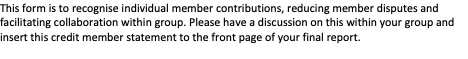
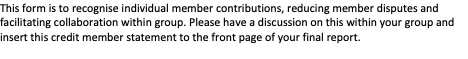
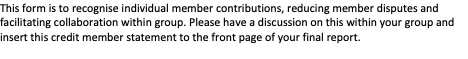
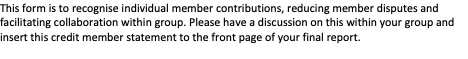

# Task 1: Dataset

# Import important libraries for the project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from kmodes.kprototypes import KPrototypes
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import dataset(s) into pandas and print samples.
fpath = '/kaggle/input/acra-information-on-corporate-entities-2019-2025/ACRA_Information_on_Corporate_Entities_2019_2025.csv'
df = pd.read_csv(fpath, low_memory=False)
pd.set_option('display.float_format', lambda x:'%f'%x)

# Print sample rows

In [ ]:
df.head(10)

# Print Columns in the Dataset

In [ ]:
print(df.columns.tolist())

-----

# Task 2: business scenarios

Determine which specific regions in Singapore are most likely to transform into major economic and innovation hubs in the near future by analyzing geospatial patterns—including postal codes, street names, and block information—derived from recent business registration data. This investigation will assess how spatial distribution and density of new businesses correlate with economic growth trends, providing actionable insights into potential hotspots for future development.

-----

# Task-3: preprocessing

# Reducing the dataset size for faster evaluation

In [ ]:
sample_size = 28000
df = df.sample(n=sample_size, random_state=42)
df.shape

# Subset the geospatial-related columns and store in sub1

In [ ]:
columns_required = [
    'uen', 'registration_incorporation_date', 'block', 'street_name', 'postal_code',
    'entity_type_description', 'primary_ssic_code', 'company_type_description',
    'entity_status_description', 'building_name', 'other_address_line1']
sub1 = df[columns_required].copy()

# Data Management

In [ ]:
# Datetime conversion
sub1['registration_incorporation_date'] = pd.to_datetime(sub1['registration_incorporation_date'], errors='coerce')

# Numeric conversion
num_cols = ['block', 'postal_code']
for col in num_cols:
    sub1[col] = pd.to_numeric(sub1[col], errors='coerce')

#Text/categorical conversion
cat_cols = ['uen', 'street_name', 'building_name', 'other_address_line1',
            'entity_type_description', 'company_type_description',
            'primary_ssic_code', 'entity_status_description']
for col in cat_cols:
    sub1[col] = sub1[col].astype(str).str.strip()

# Null values before dropna

In [ ]:
print(sub1.isnull().sum())

# Drop rows with null values across all columns in sub1

In [ ]:
sub1 = sub1.dropna(subset=sub1.columns.tolist())

# Check for null values after dropping rows with any missing data

In [ ]:
print(sub1.isnull().sum())

# Scaling Features

In [ ]:
# Standard Scaling
sub1[['block', 'postal_code']] = StandardScaler().fit_transform(sub1[['block', 'postal_code']])

# Min-Max Scaling
sub1[['block', 'postal_code']] = MinMaxScaler().fit_transform(sub1[['block', 'postal_code']])

-----

# Task-4: SVM

# Creating region and hub_label

In [ ]:
sub_svm = sub1.copy()
sub_svm['region'] = sub_svm['postal_code'].astype(str) + '_' + sub_svm['street_name']
region_counts = sub_svm.groupby('region').size().reset_index(name='region_count')
sub_svm = sub_svm.merge(region_counts, on='region', how='left')

median_count = sub_svm['region_count'].median()
sub_svm['hub_label'] = np.where(sub_svm['region_count'] > median_count, 1, 0)

In [ ]:
X_svm = sub_svm[['block', 'postal_code', 'region_count']]
y_svm = sub_svm['hub_label']
X_svm_scaled = StandardScaler().fit_transform(X_svm)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
svm = SVC(kernel='sigmoid', probability=True, random_state=42)
print("SVM Cross-Validation Accuracy:", cross_val_score(svm, X_svm_scaled, y_svm, cv=skf, 
                                                        scoring='accuracy'))

# Predictions & Evaluation

In [ ]:
# Get cross-validated predictions
y_pred_svm = cross_val_predict(svm, X_svm_scaled, y_svm, cv=skf, n_jobs=-1)

# Print classification report
print(classification_report(y_svm, y_pred_svm))

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_svm, y_pred_svm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC score

In [ ]:
roc_auc = roc_auc_score(y_svm, svm.fit(X_svm_scaled, y_svm).predict_proba(X_svm_scaled)[:, 1])
print("ROC AUC Score:", roc_auc)

# Final Prediction

In [ ]:
# Predicted probabilities using cross_val_predict
svm_probs = cross_val_predict(svm, X_svm_scaled, y_svm, cv=skf, method='predict_proba', 
                              n_jobs=-1)[:, 1]

# --- Step 8: Create results DataFrame ---
results_df = pd.DataFrame({
    'region': sub_svm['region'],
    'true_label': y_svm,
    'predicted_prob': svm_probs
})

# Group by region and sort
region_forecast = results_df.groupby('region').agg(
    avg_prob=('predicted_prob', 'mean'),
    sample_count=('region', 'count')
).reset_index()

# Add a weighted score = avg_prob * log(sample_count)
region_forecast['weighted_score'] = region_forecast['avg_prob'] * np.log1p(region_forecast
                                                                           ['sample_count'])

# Sort by the weighted score
region_forecast_sorted = region_forecast.sort_values(by='weighted_score', ascending=False)

print("\nTop Weighted Regions by Hub Likelihood and Density:")
print(region_forecast_sorted.head(10))

-----

# Task-5: Random Forest

# Create Region & Year from sub_rf

In [ ]:
sub_rf = sub1.copy()
sub_rf['postal_code_raw'] = sub_rf['postal_code'].astype(str).str.zfill(6)
sub_rf['region'] = sub_rf['postal_code_raw'] + '_' + sub_rf['street_name']
sub_rf['year'] = sub_rf['registration_incorporation_date'].dt.year

# Create Growth-Based Label

In [ ]:
region_yearly = sub_rf.groupby(['region', 'year']).size().reset_index(name='count')
region_latest = region_yearly.sort_values('year', ascending=False).groupby('region').first().reset_index()
growth_threshold = region_latest['count'].quantile(0.90)

# Merge back to sub_rf

In [ ]:
sub_rf = sub_rf.merge(region_latest[['region', 'count']], on='region', how='left')
sub_rf['hub_label'] = (sub_rf['count'] > growth_threshold).astype(int)

# Remove label-defining feature

In [ ]:
features = ['block', 'postal_code', 'entity_type_description', 'company_type_description',
            'primary_ssic_code', 'entity_status_description']
X = sub_rf[features]
y = sub_rf['hub_label']

# Preprocessing Pipeline

In [ ]:
categorical_cols = ['entity_type_description', 'company_type_description',
                    'primary_ssic_code', 'entity_status_description']
numerical_cols = ['block', 'postal_code']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 3-Fold Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print("3-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))

# Train/Test Split & Model Fit

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

# Predictions & Evaluation

In [ ]:
y_pred = pipeline.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Predicting Hub Probabilities by Region

In [ ]:
pipeline.fit(X, y)
y_probs = pipeline.predict_proba(X)[:, 1]

region_scores = pd.DataFrame({
    'region': sub_rf['region'],
    'hub_prob': y_probs
})
region_summary = region_scores.groupby('region').agg(
    avg_prob=('hub_prob', 'mean'),
    sample_count=('hub_prob', 'count')
).reset_index().sort_values(by='avg_prob', ascending=False)

# Compute Weighted Score & Display Top Region

In [ ]:
# Compute weighted score: combine avg_prob with sample_count using log scale
region_summary['weighted_score'] = region_summary['avg_prob'] * np.log1p(region_summary['sample_count'])

# Sort regions based on the weighted score
region_summary_sorted = region_summary.sort_values(by='weighted_score', ascending=False)

# Display top regions with high likelihood and density
print("\nTop Weighted Regions by Hub Likelihood and Density:")
print(region_summary_sorted.head(10))

# Task-6: Clustring

In [ ]:
# Region Engineering & Aggregation
sub_kproto = sub1.copy()
sub_kproto['postal_code_raw'] = sub_kproto['postal_code'].astype(str).str.zfill(6)
sub_kproto['region'] = sub_kproto['postal_code_raw'] + '_' + sub_kproto['street_name']

In [ ]:
# Aggregated Features for Clustering
agg = sub_kproto.groupby('region').agg(
    block_mean=('block', 'mean'),
    reg_count=('uen', 'count'),
    ssic_mode=('primary_ssic_code', lambda x: x.mode().iat[0] if not x.mode().empty else np.nan),
    entity_mode=('entity_type_description', lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
).reset_index()

In [ ]:
# K-Prototypes Clustering
kproto_data = agg[['block_mean', 'reg_count', 'ssic_mode', 'entity_mode']].copy()
kproto_data.fillna("missing", inplace=True)

kproto_model = KPrototypes(n_clusters=4, init='Cao', verbose=0, random_state=42)
kproto_data_matrix = kproto_model.fit_predict(kproto_data, categorical=[2, 3])
agg['cluster'] = kproto_data_matrix

In [ ]:
# Analyze Key Clusters to Identify Innovation Hubs
for i in range(agg['cluster'].nunique()):
    cluster_df = agg[agg['cluster'] == i]
    print(f"\n🔍 Cluster {i} Summary:")
    print(cluster_df[['region', 'block_mean', 'reg_count', 'ssic_mode', 'entity_mode']]
          .sort_values(by='reg_count', ascending=False).head(5))

In [ ]:
# Score Regions Based on Cluster Size & Business Density
cluster_summary = agg.groupby('cluster').agg(
    avg_density=('reg_count', 'mean'),
    total_regions=('region', 'count')
).sort_values(by='avg_density', ascending=False)

print("\n🏆 Cluster Summary Ranking by Average Density:")
print(cluster_summary)

In [ ]:
# Output Top Ranked Regions
top_cluster = cluster_summary.index[0]
top_regions = agg[agg['cluster'] == top_cluster].sort_values(by='reg_count', ascending=False)

print("\n🌟 Top Regions in Cluster Likely to Become Innovation Hubs:")
print(top_regions.head(10)[['region', 'reg_count', 'ssic_mode', 'entity_mode']])